In [1]:
import spacy
import json
import gensim
from collections import Counter
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from pprint import pprint
import numpy as np
np.random.seed(2042)

import pandas as pd
pd.options.display.max_colwidth = 400

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

import pyLDAvis
import pyLDAvis.gensim_models

from wordcloud import WordCloud

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[nltk_data] Downloading package wordnet to /Users/harshit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## READ FINANCIAL DATA

In [2]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"
df_all = pd.read_csv(url)

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/05/21,Credit card or prepaid card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,"I had two active cards with citi Bank diamond and citi bank double cash .i was affected by covid and i could only pay the minimum and when I received other money i would send extra. I was trying to get my usage down so 1. So can get my credit rating backup due to a XXXX breach of my personal info that caused an avalanche of credit problems with XXXX XXXX, ( who is going through problems that h...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",MA,02122,None,Consent provided,Web,03/05/21,Closed with explanation,Yes,NaN,4187485
1,03/12/21,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,"I received a letter of a alleged collection of a debt I did not own nor authorize, nor sign any documentation hereto ... Convergent Outsourcing INc, contacted me in representation of XXXX XXXX another 3rd party collection company, that purchased from XXXX XXXX XXXX XXXX ... in representation of XXXX that discharged and charge off of a account I did not authorize, nor owe ... complete fraud on ...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"Convergent Resources, Inc.",PA,19030,None,Consent provided,Web,03/12/21,Closed with explanation,Yes,NaN,4208322
2,03/10/21,Credit card or prepaid card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,"I've been trying to make purchases online in XXXX with my U.S. Capital One credit card. They put a block on my account. I understand that they were concerned about fraudulent charges on my account. Up to that point, no problem. \n\nThey asked me to call them to confirm that I had made the purchases, which by the way were less than {$500.00} and on XXXX, a reputable site some might say, with th...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,95472,None,Consent provided,Web,03/10/21,Closed with non-monetary relief,Yes,NaN,4202863


# Visualization

## 1. Product Distribution

<AxesSubplot:>

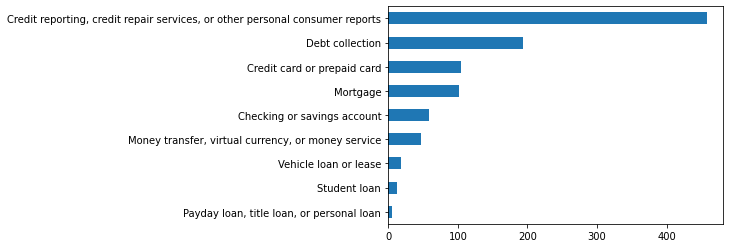

In [3]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

## 2. Issue Distribution

<AxesSubplot:>

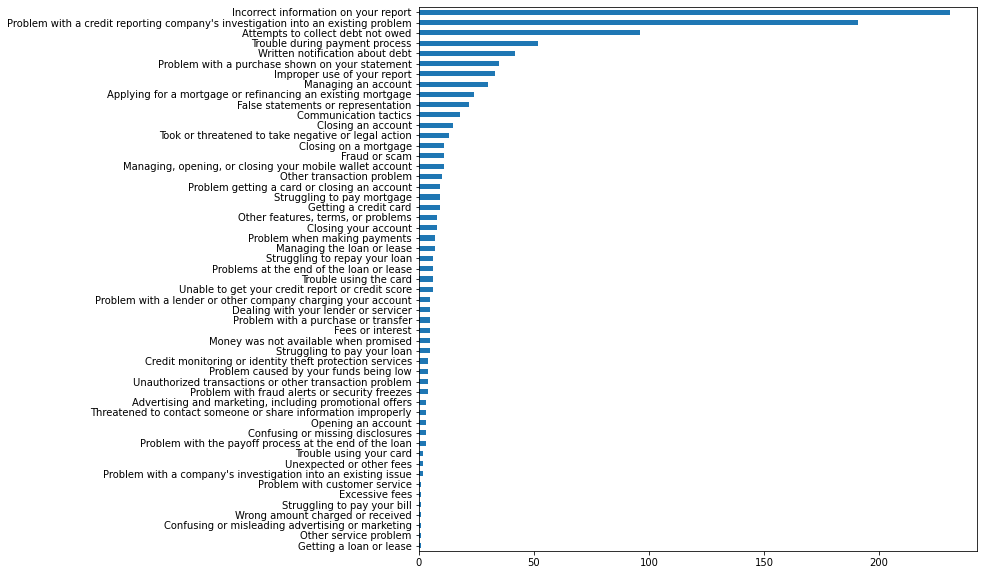

In [4]:
df['Issue'].value_counts().sort_values().plot(kind='barh', figsize=(10,10)) 

# 3. Company Distribution

<AxesSubplot:>

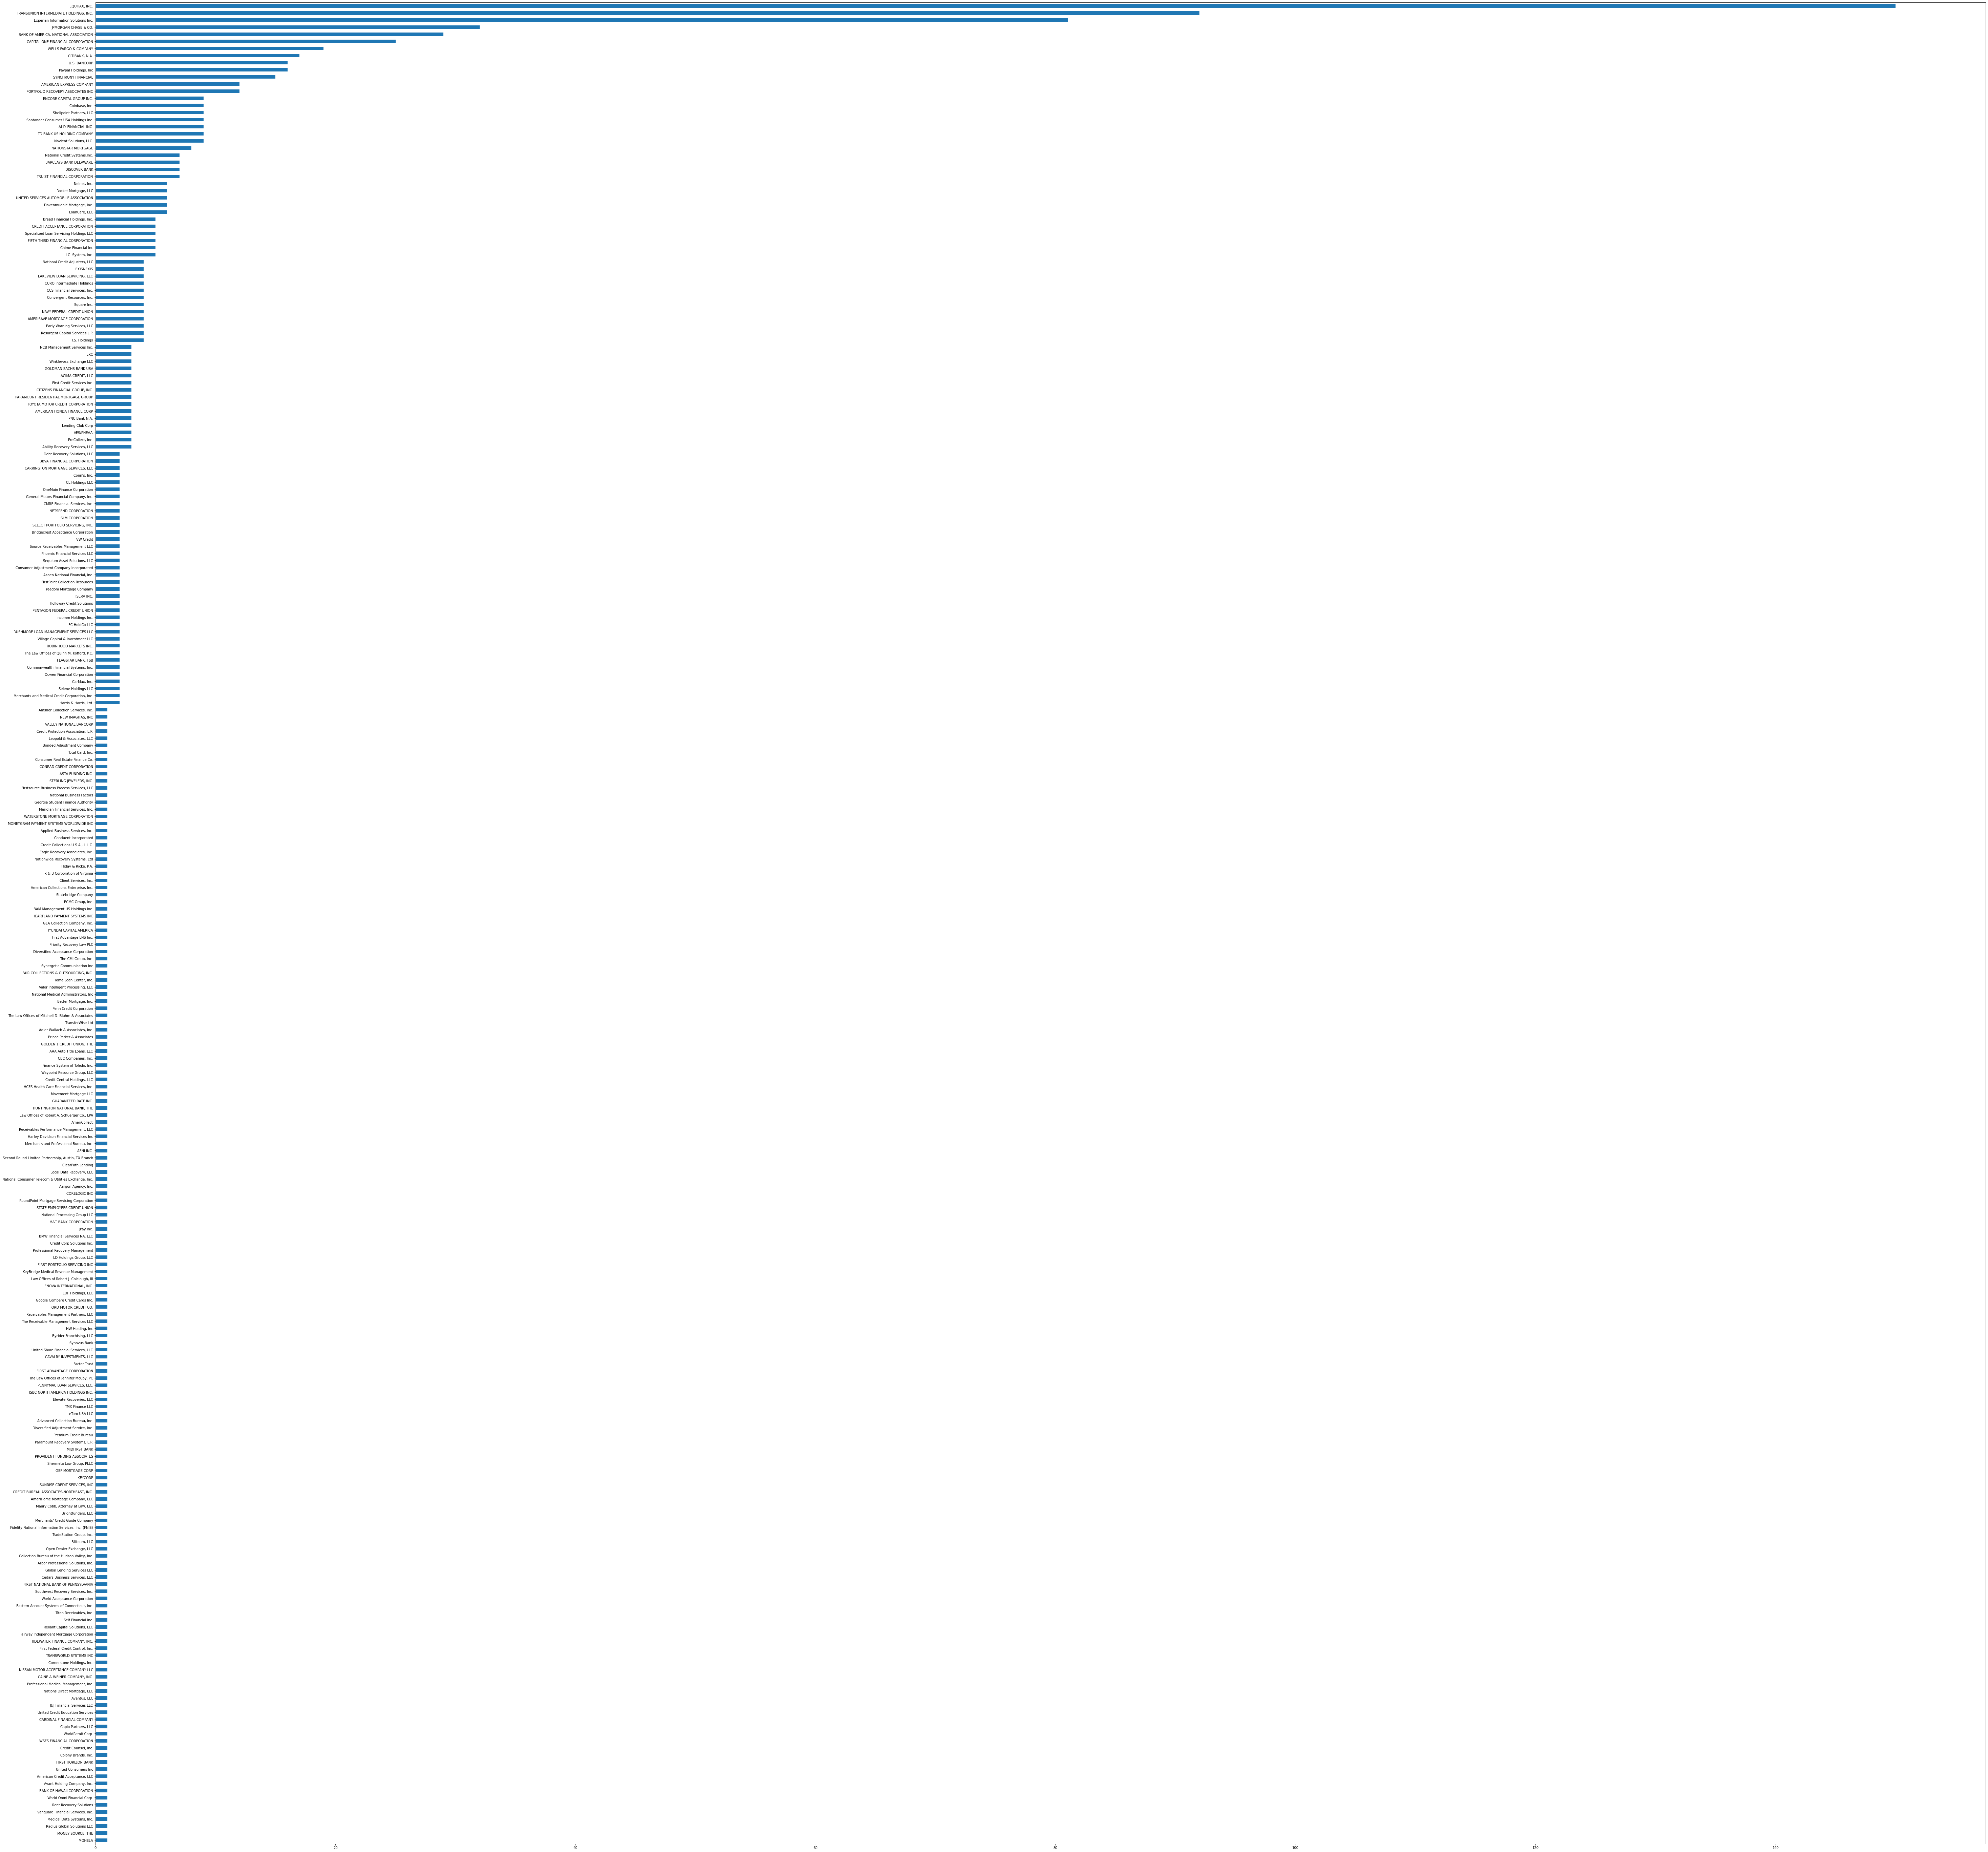

In [5]:
df['Company'].value_counts().sort_values().plot(kind='barh', figsize=(100,100)) 

## 4. State Distribution

<AxesSubplot:>

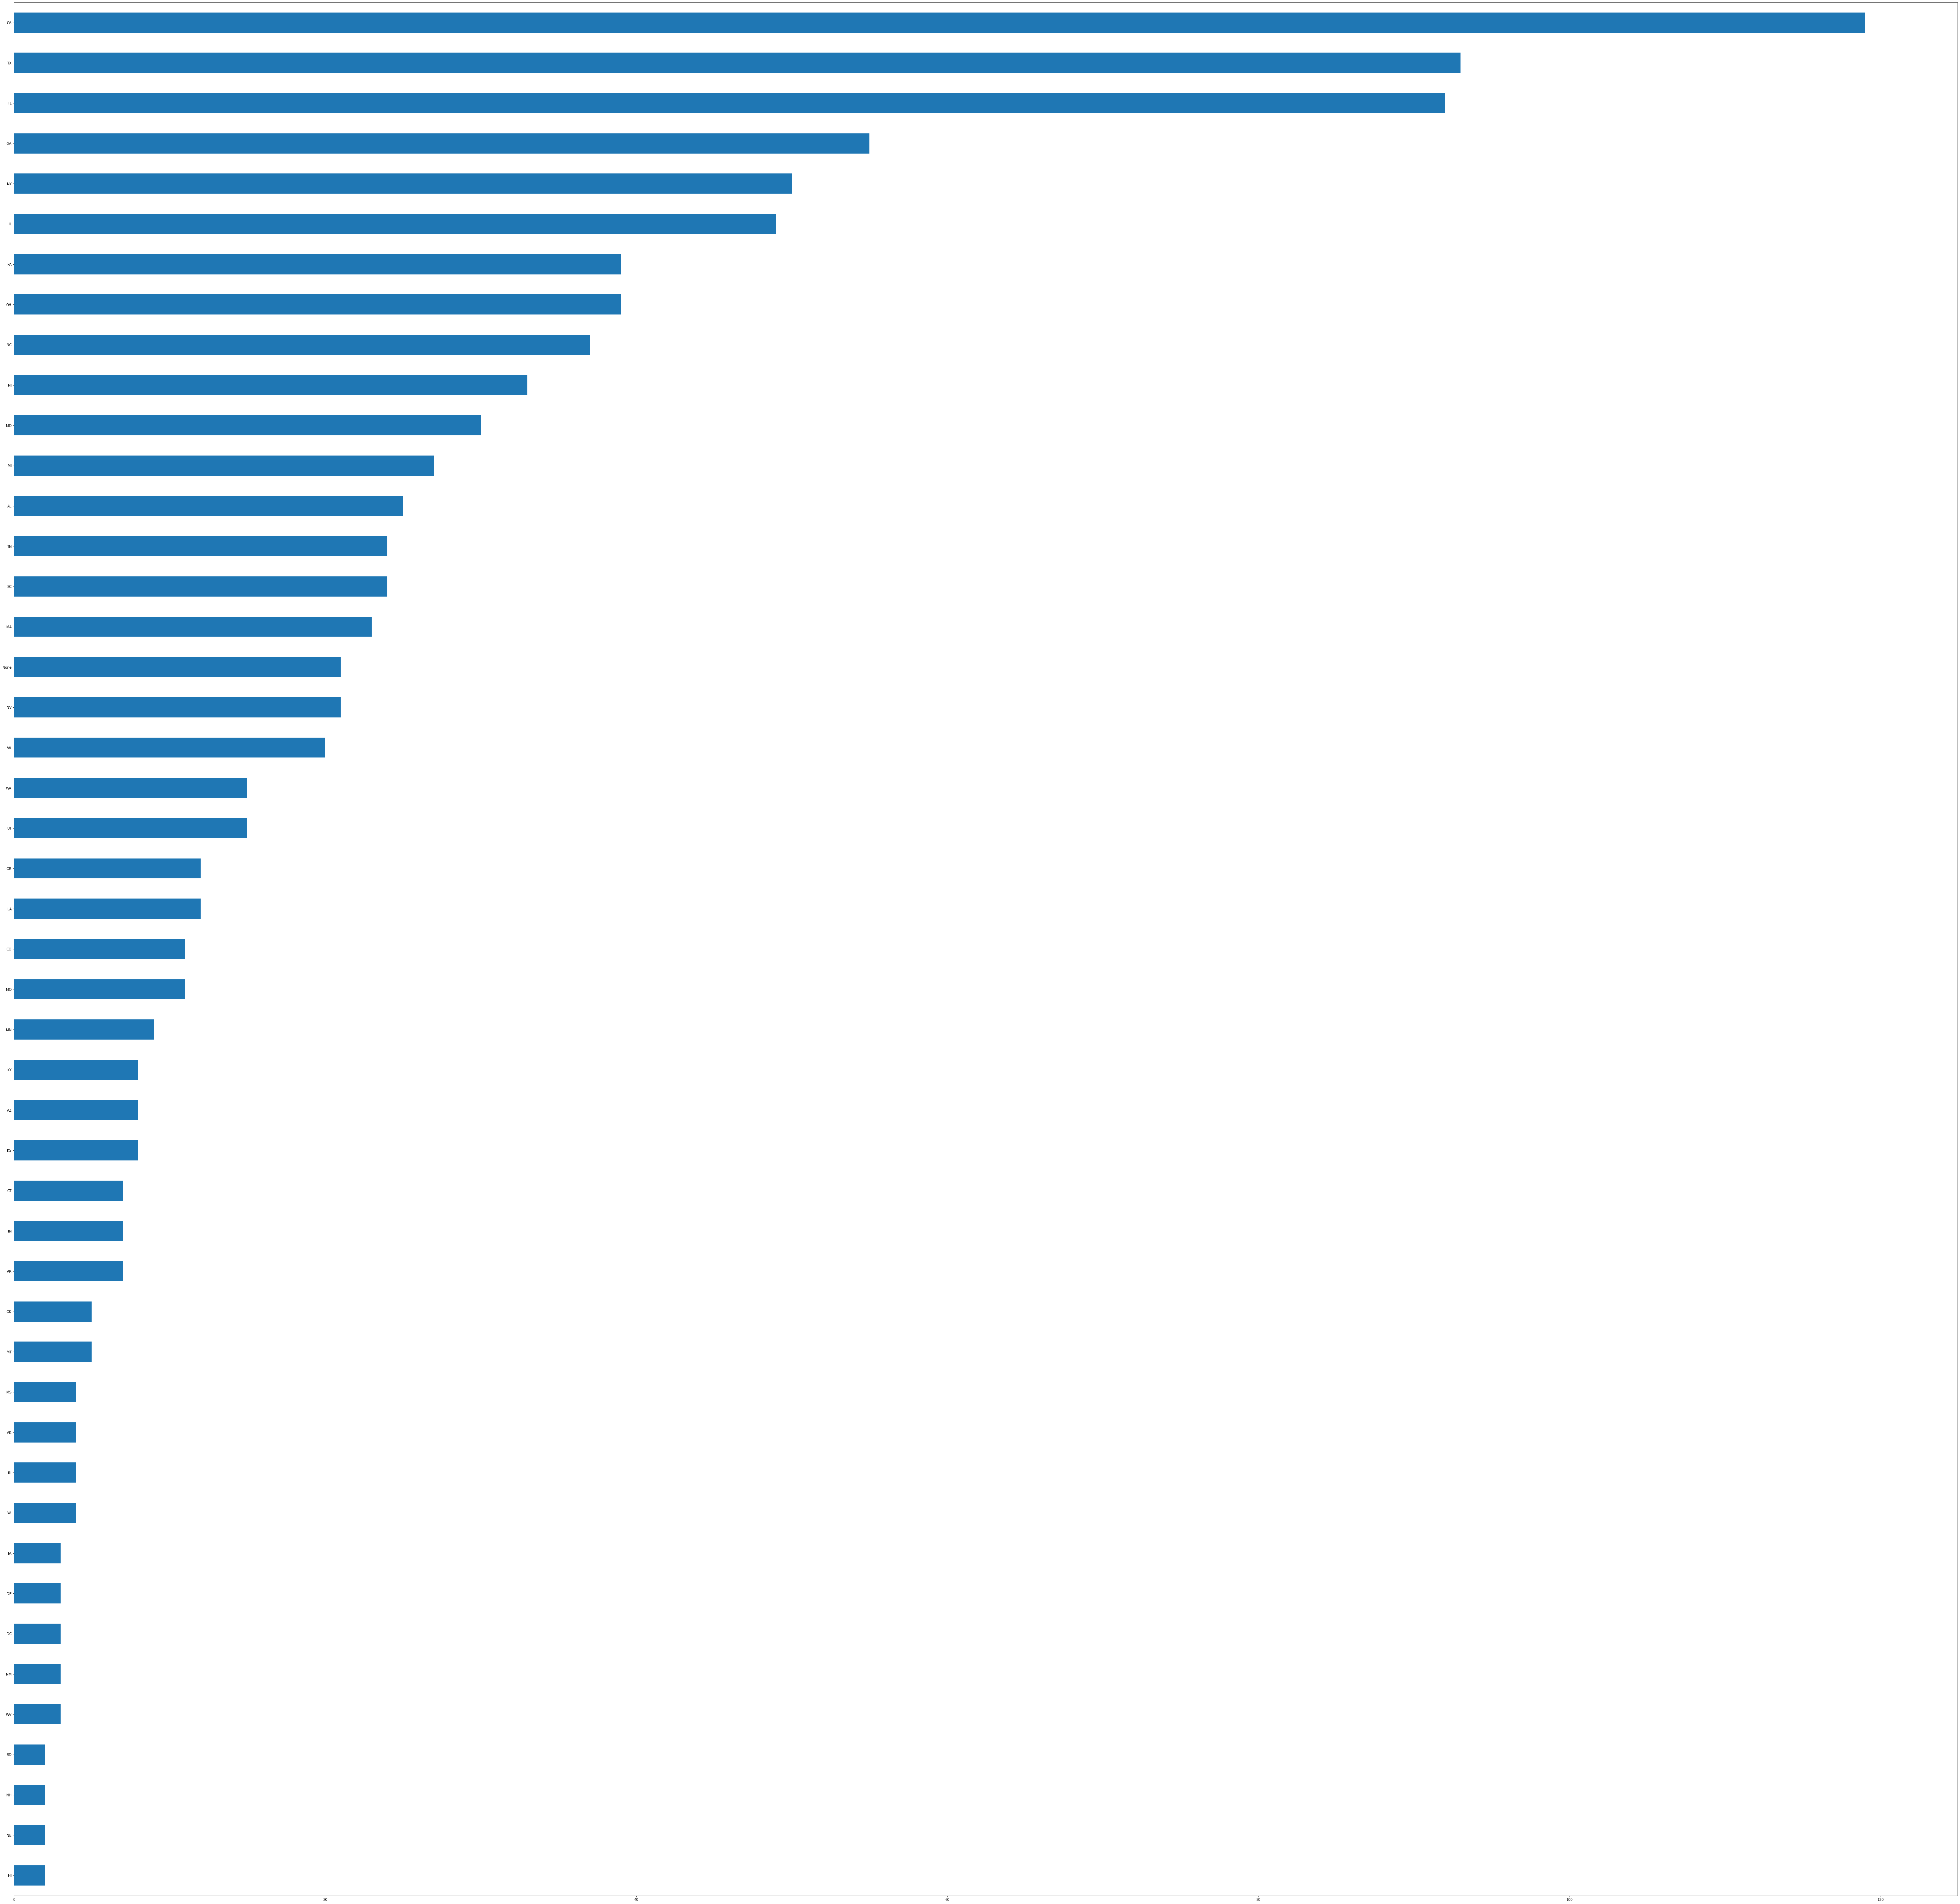

In [6]:
df['State'].value_counts().sort_values().plot(kind='barh', figsize=(100,100)) 

- Consumer complains are under the column `Consumer complaint narrative`. 
- We will focus on text contained in this column.
- Goal is to determine topics in this corpus
- predict topic for each complaint

In [7]:
text_col = 'Consumer complaint narrative'
dataset = df[text_col]
print("# of records", len(dataset))
print(dataset[0])

# of records 1000
I had two active cards with citi Bank diamond and citi bank double cash .i was affected by covid and i could only pay the minimum and when I received other money i would send extra. I was trying to get my usage down so 1. So can get my credit rating backup due to a XXXX breach of my personal info that caused an avalanche of credit problems with XXXX XXXX, ( who is going through problems that has affected many of their consumers ) this breach causing me to fall behind because many of my payments were sent back to my creditors unknown to me. XXXX i could not reach citibank until XXXX of XXXX. When i did reach them I asked Citi Bank how were they assisting their customers during the pandemic since i am XXXX XXXX and following the rules that the governor set? They offer two months and i managed to pay extra, my accounts were over the limits due to interest fees late fees and usage. We were in a global pandemic, i had to feed my children and help them adjust to remote lear

- The input to function `sent_to_words` is a `list of sentences`
- output is a list of list
- each list contains tokens after removing emails,new lines, single quotes, and special symbol `XXX`

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\s*\bX+\b\s*', ' ', sent)
        sent = sent.strip()
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

<>:5: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
/var/folders/k0/tdjkjj3942vdpnc33747lk2c0000gn/T/ipykernel_61287/487013516.py:5: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
/var/folders/k0/tdjkjj3942vdpnc33747lk2c0000gn/T/ipykernel_61287/487013516.py:6: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


In [9]:
data_words = list(sent_to_words(dataset))
print(data_words[0])

['had', 'two', 'active', 'cards', 'with', 'citi', 'bank', 'diamond', 'and', 'citi', 'bank', 'double', 'cash', 'was', 'affected', 'by', 'covid', 'and', 'could', 'only', 'pay', 'the', 'minimum', 'and', 'when', 'received', 'other', 'money', 'would', 'send', 'extra', 'was', 'trying', 'to', 'get', 'my', 'usage', 'down', 'so', 'so', 'can', 'get', 'my', 'credit', 'rating', 'backup', 'due', 'to', 'breach', 'of', 'my', 'personal', 'info', 'that', 'caused', 'an', 'avalanche', 'of', 'credit', 'problems', 'with', 'who', 'is', 'going', 'through', 'problems', 'that', 'has', 'affected', 'many', 'of', 'their', 'consumers', 'this', 'breach', 'causing', 'me', 'to', 'fall', 'behind', 'because', 'many', 'of', 'my', 'payments', 'were', 'sent', 'back', 'to', 'my', 'creditors', 'unknown', 'to', 'me', 'could', 'not', 'reach', 'citibank', 'until', 'of', 'when', 'did', 'reach', 'them', 'asked', 'citi', 'bank', 'how', 'were', 'they', 'assisting', 'their', 'customers', 'during', 'the', 'pandemic', 'since', 'am', 

# What does the following code snippet do?

- remove stop words from each complaint
- combine tokens into bigrams

In [10]:
bigram = gensim.models.Phrases(data_words, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
#     texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
#     texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [11]:
data_ready = process_words(data_words)
print("Ex: Consumer Complaint as list of tokens => \n",data_ready[0])

Ex: Consumer Complaint as list of tokens => 
 ['active', 'card', 'citi_bank', 'diamond', 'citi_bank', 'double', 'cash', 'covid', 'pay', 'minimum', 'receive', 'money', 'send', 'extra', 'usage', 'credit_rating', 'backup', 'breach', 'personal', 'info', 'cause', 'avalanche', 'credit', 'problem', 'problem', 'affect', 'consumer', 'breach', 'fall', 'behind', 'payments_were', 'send', 'back', 'creditor', 'unknown', 'could_not', 'reach', 'citibank', 'reach', 'ask', 'assist', 'their_customer', 'pandemic', 'follow', 'rule', 'governor', 'set', 'offer', 'two_month', 'manage', 'pay', 'extra', 'account', 'limit', 'interest', 'fee', 'late_fee', 'usage', 'we_were', 'global', 'pandemic', 'feed', 'child', 'help', 'adjust', 'remote', 'learning', 'home', 'first_time', 'computer', 'location', 'needless', 'work', 'set', 'computer', 'location', 'computer', 'location', 'access', 'soon', 'learn', 'access', 'area', 'underserved', 'community', 'different', 'difficulty', 'reach', 'citibank', 'reach', 'phone', 'woul

## Create dictionary
## <u> Bag of Words</u> Representation for each Complaint

In [12]:
id2word = Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [13]:
bow_doc_0 = corpus[0]
print("\nBOW DOCUMENT=>\n",bow_doc_0)
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               id2word[bow_doc_0[i][0]], bow_doc_0[i][1]))


BOW DOCUMENT=>
 [(0, 2), (1, 3), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 2), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 2), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 3), (69, 4), (70, 2), (71, 2), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 3), (81, 10), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 1), (90, 5), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2), (97, 3), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (

In [14]:
print("Consumer Complaint as list of tokens (unigram or bigram) =>\n",data_ready[0])

longText = [' '.join(dr) for dr in data_ready]
print("Consumer Complaint =>\n",longText[0])

realy_log_Text = ' '.join(longText)

Consumer Complaint as list of tokens (unigram or bigram) =>
 ['active', 'card', 'citi_bank', 'diamond', 'citi_bank', 'double', 'cash', 'covid', 'pay', 'minimum', 'receive', 'money', 'send', 'extra', 'usage', 'credit_rating', 'backup', 'breach', 'personal', 'info', 'cause', 'avalanche', 'credit', 'problem', 'problem', 'affect', 'consumer', 'breach', 'fall', 'behind', 'payments_were', 'send', 'back', 'creditor', 'unknown', 'could_not', 'reach', 'citibank', 'reach', 'ask', 'assist', 'their_customer', 'pandemic', 'follow', 'rule', 'governor', 'set', 'offer', 'two_month', 'manage', 'pay', 'extra', 'account', 'limit', 'interest', 'fee', 'late_fee', 'usage', 'we_were', 'global', 'pandemic', 'feed', 'child', 'help', 'adjust', 'remote', 'learning', 'home', 'first_time', 'computer', 'location', 'needless', 'work', 'set', 'computer', 'location', 'computer', 'location', 'access', 'soon', 'learn', 'access', 'area', 'underserved', 'community', 'different', 'difficulty', 'reach', 'citibank', 'reach',

## Generate Word Cloud of all the terms in the consumer complaints

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orient

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 inst

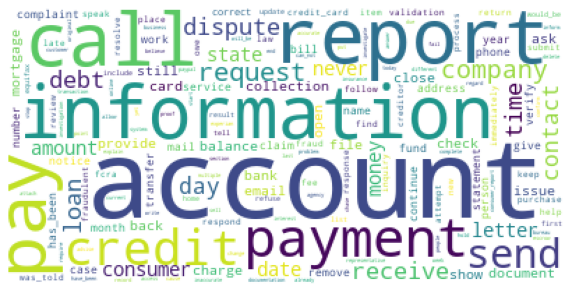

In [15]:
# generate the word cloud
wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(realy_log_Text)
# visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Word Distribution across all consumer complaints

<AxesSubplot:xlabel='words', ylabel='count'>

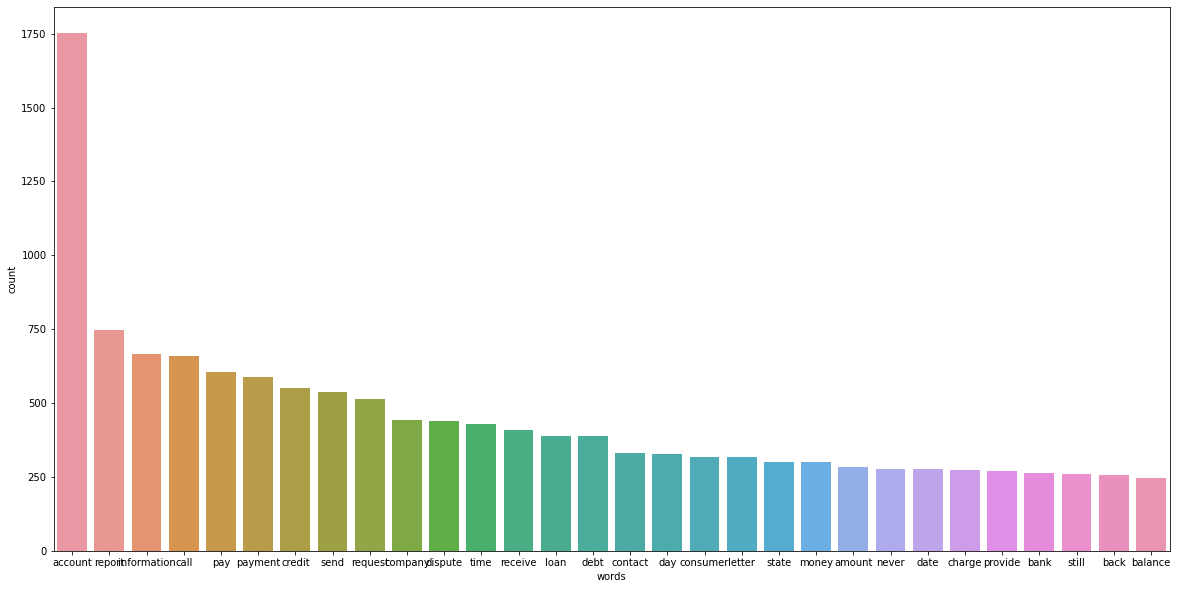

In [16]:
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = realy_log_Text.split()
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(30)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

# How many topics?
1. Let us start with a random number 4 as number of topics

In [17]:
lda_model_bow_4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [18]:
pprint(lda_model_bow_4.print_topics())

[(0,
  '0.048*"account" + 0.014*"report" + 0.010*"information" + 0.009*"payment" + '
  '0.008*"send" + 0.007*"open" + 0.007*"credit" + 0.007*"dispute" + '
  '0.007*"day" + 0.007*"bank"'),
 (1,
  '0.024*"account" + 0.012*"call" + 0.011*"send" + 0.009*"report" + '
  '0.009*"debt" + 0.008*"pay" + 0.008*"letter" + 0.007*"money" + 0.007*"loan" '
  '+ 0.007*"check"'),
 (2,
  '0.017*"call" + 0.016*"pay" + 0.013*"payment" + 0.012*"account" + '
  '0.010*"company" + 0.009*"loan" + 0.009*"send" + 0.008*"receive" + '
  '0.008*"time" + 0.007*"credit"'),
 (3,
  '0.024*"information" + 0.021*"consumer" + 0.021*"report" + 0.016*"request" + '
  '0.015*"dispute" + 0.014*"credit" + 0.013*"account" + 0.008*"validation" + '
  '0.007*"fcra" + 0.007*"consumer_report"')]


# What is the coherence of topic clusters

In [19]:
coherencemodel = CoherenceModel(model=lda_model_bow_4, texts=data_ready, dictionary=id2word, coherence='c_v')
print(coherencemodel.get_coherence())

0.29744480468956086


# Visualize the topic clusters

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_bow_4, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.088472  0.049758       1        1  35.853594
0      0.028289 -0.072121       2        1  28.208993
1      0.057392  0.006619       3        1  20.114807
3     -0.174154  0.015744       4        1  15.822607, topic_info=            Term         Freq        Total Category  logprob  loglift
29      consumer   292.000000   292.000000  Default  30.0000  30.0000
2        account  1613.000000  1613.000000  Default  29.0000  29.0000
283  information   615.000000   615.000000  Default  28.0000  28.0000
557       report   684.000000   684.000000  Default  27.0000  27.0000
18          call   622.000000   622.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
436         date    48.870343   254.807827   Topic4  -5.3522   0.1924
124         debt    51.752355   360.060521   Topic4  -5.2949  -0.0961
449      address    42.331420   179.315411   Topic4  -5.4958   0.4001
555      provide    42.331967   252.683506   Topic4  -5.4958   0.0571
104         time    43.851545   403.354581   Topic4  -5.4605  -0.3753

[337 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         1  0.170738       access
1         2  0.694334       access
1         3  0.079678       access
1         4  0.068295       access
1608      1  0.018282  accordingly
...     ...       ...          ...
427       4  0.047348   would_take
117       1  0.269372          yet
117       2  0.280147          yet
117       3  0.387896          yet
117       4  0.053874          yet

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

# Visualization of documents to topics

In [21]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_bow_4[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 998 samples in 0.001s...
[t-SNE] Computed neighbors for 998 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 998 / 998
[t-SNE] Mean sigma: 0.001469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.185688
[t-SNE] KL divergence after 1000 iterations: 0.213151


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/harshit/miniconda3/envs/tutorial/lib/python3.8/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


# Is there a way to Identify the BEST Coherent Clusters?

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        print("number of topics ", num_topics, " has coherence value", coherence_value)
        coherence_values.append(coherence_value)

    return model_list, coherence_values

In [23]:
# this step will take some time to finish
model_list_bow, coherence_values_bow = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=42, step=2)

number of topics  2  has coherence value 0.23987696784040108
number of topics  4  has coherence value 0.29744480468956086
number of topics  6  has coherence value 0.28099818281278316
number of topics  8  has coherence value 0.26515255536226334
number of topics  10  has coherence value 0.2884702492584318
number of topics  12  has coherence value 0.28271040488056304
number of topics  14  has coherence value 0.2854167597462137
number of topics  16  has coherence value 0.27893127523517824
number of topics  18  has coherence value 0.29184606095885657
number of topics  20  has coherence value 0.30537548180271246
number of topics  22  has coherence value 0.32009223346121685
number of topics  24  has coherence value 0.2924459429834088
number of topics  26  has coherence value 0.28649662722749436
number of topics  28  has coherence value 0.29872812840744195
number of topics  30  has coherence value 0.2973225856329095
number of topics  32  has coherence value 0.30164162413605067
number of topics

# Visualize Coherence

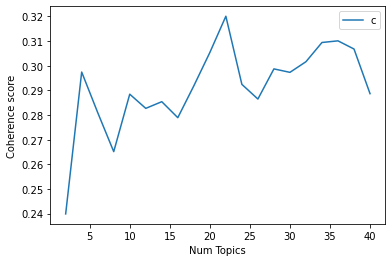

In [24]:
limit=42; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_bow)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_bow"), loc='best')
plt.show()

# Visualize the topic clusters = 22

In [34]:
vis = pyLDAvis.gensim_models.prepare(model_list_bow[10], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.116793  0.015998       1        1  14.499505
7     -0.057042  0.068614       2        1  10.520402
19     0.107160  0.027247       3        1   9.002521
8     -0.216057  0.006380       4        1   6.692414
14    -0.100143  0.117568       5        1   6.418910
15     0.039504  0.055119       6        1   5.408269
9      0.068856  0.012484       7        1   5.087133
10     0.149749 -0.061709       8        1   4.690962
6     -0.052219  0.022387       9        1   4.607821
2      0.072962 -0.006144      10        1   3.749585
20     0.100409 -0.012722      11        1   3.501060
0     -0.031577 -0.026325      12        1   3.379696
4     -0.004637  0.068400      13        1   3.313349
1     -0.026357  0.040213      14        1   2.899112
11     0.096437 -0.005970      15        1   2.617517
12     0.029783 -0.024545      16        1   2.540786
3     -0.198442 -0.066516      17        1   2.434635
21     0.080635  0.022099      18        1   2.163239
16    -0.138374 -0.008257      19        1   1.924848
17     0.074592 -0.022187      20        1   1.877001
18    -0.070108  0.019602      21        1   1.421628
5     -0.041922 -0.241734      22        1   1.249606, topic_info=            Term         Freq        Total Category  logprob  loglift
2        account  1644.000000  1644.000000  Default  30.0000  30.0000
283  information   615.000000   615.000000  Default  29.0000  29.0000
29      consumer   296.000000   296.000000  Default  28.0000  28.0000
383      payment   545.000000   545.000000  Default  27.0000  27.0000
557       report   690.000000   690.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
542    complaint     3.977698   185.767674  Topic22  -5.3220   0.5385
173        email     3.965899   207.791811  Topic22  -5.3250   0.4235
557       report     3.987307   690.658560  Topic22  -5.3196  -0.7722
123      contact     3.792166   318.269937  Topic22  -5.3698  -0.0476
485        issue     3.704129   205.034870  Topic22  -5.3933   0.3686

[1663 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1102      5  0.271638       abandon
1102      6  0.543276       abandon
4043     10  0.289978         abide
4043     19  0.579957         abide
2075      3  0.454240       ability
...     ...       ...           ...
2736      5  0.230461  your_company
2736      7  0.076820  your_company
2736      9  0.153641  your_company
2736     19  0.460923  your_company
2929     12  0.691431   your_office

[5499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 20, 9, 15, 16, 10, 11, 7, 3, 21, 1, 5, 2, 12, 13, 4, 22, 17, 18, 19, 6])

# TFIDF Representation of Consumer Complaints

In [25]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [26]:
test_document = data_ready[0]
print("ACTUAL DOC=>\n",test_document)
print("====tfidf====")
tfidf_doc_0 = corpus_tfidf[0]
for i in range(len(tfidf_doc_0)):
    print("Word {} (\"{}\") weight {}.".format(tfidf_doc_0[i][0], 
                                               id2word[tfidf_doc_0[i][0]], tfidf_doc_0[i][1]))

ACTUAL DOC=>
 ['active', 'card', 'citi_bank', 'diamond', 'citi_bank', 'double', 'cash', 'covid', 'pay', 'minimum', 'receive', 'money', 'send', 'extra', 'usage', 'credit_rating', 'backup', 'breach', 'personal', 'info', 'cause', 'avalanche', 'credit', 'problem', 'problem', 'affect', 'consumer', 'breach', 'fall', 'behind', 'payments_were', 'send', 'back', 'creditor', 'unknown', 'could_not', 'reach', 'citibank', 'reach', 'ask', 'assist', 'their_customer', 'pandemic', 'follow', 'rule', 'governor', 'set', 'offer', 'two_month', 'manage', 'pay', 'extra', 'account', 'limit', 'interest', 'fee', 'late_fee', 'usage', 'we_were', 'global', 'pandemic', 'feed', 'child', 'help', 'adjust', 'remote', 'learning', 'home', 'first_time', 'computer', 'location', 'needless', 'work', 'set', 'computer', 'location', 'computer', 'location', 'access', 'soon', 'learn', 'access', 'area', 'underserved', 'community', 'different', 'difficulty', 'reach', 'citibank', 'reach', 'phone', 'would_be', 'hour', 'access', 'intern

# Train LDA Model on TfIdf Corpus

In [27]:
lda_model_tfidf_2 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=id2word, passes=2, workers=2)

In [28]:
coherencemodel_tfidf_2 = CoherenceModel(model=lda_model_tfidf_2, texts=data_ready, dictionary=id2word, coherence='c_v')
print(coherencemodel_tfidf_2.get_coherence())

0.2317029553821343


# Visualize the LDA topic on TfIdf corpus with 2 topics

In [29]:
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
0      0.008453  0.0       1        1  92.60999
1     -0.008453  0.0       2        1   7.39001, topic_info=            Term        Freq       Total Category  logprob  loglift
549       result  132.000000  132.000000  Default  30.0000  30.0000
2        account  248.000000  248.000000  Default  29.0000  29.0000
124         debt  131.000000  131.000000  Default  28.0000  28.0000
169          day  113.000000  113.000000  Default  27.0000  27.0000
283  information  142.000000  142.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
81           pay    7.039351  161.654389   Topic2  -6.5285  -0.5289
262         bank    5.863982   96.365469   Topic2  -6.7112  -0.1943
551      dispute    6.637694  182.598491   Topic2  -6.5873  -0.7095
123      contact    5.874858  112.098691   Topic2  -6.7094  -0.3437
121      company    5.996851  172.877563   Topic2  -6.6888  -0.7563

[164 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2         1  0.946491       account
2         2  0.056387       account
449       1  0.955483       address
449       2  0.047184       address
847       1  0.959691     agreement
...     ...       ...           ...
2568      2  0.144635  wrong_person
664       1  0.961179          year
664       2  0.036968          year
2736      1  0.740488  your_company
2736      2  0.246829  your_company

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [30]:
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        print("number of topics ", num_topics, " has coherence value", coherence_value)
        coherence_values.append(coherence_value)

    return model_list, coherence_values

In [39]:
model_list_tfidf, coherence_values_tfidf = compute_coherence_values_multicore(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, start=2, limit=42, step=2)

number of topics  2  has coherence value 0.23595306587832005
number of topics  4  has coherence value 0.28061674484158344
number of topics  6  has coherence value 0.30604395183293875
number of topics  8  has coherence value 0.45398837614872306
number of topics  10  has coherence value 0.4283685056044465
number of topics  12  has coherence value 0.4925103619821594
number of topics  14  has coherence value 0.4110435971884768
number of topics  16  has coherence value 0.49109917341809967
number of topics  18  has coherence value nan
number of topics  20  has coherence value nan
number of topics  22  has coherence value nan
number of topics  24  has coherence value nan
number of topics  26  has coherence value nan
number of topics  28  has coherence value 0.5400678391444543
number of topics  30  has coherence value nan
number of topics  32  has coherence value nan
number of topics  34  has coherence value nan
number of topics  36  has coherence value nan
number of topics  38  has coherence 

# Visualize Coherence

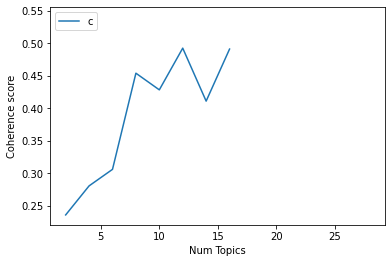

In [38]:
limit=42; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_tfidf)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_bow"), loc='best')
plt.show()

In [32]:
pprint(model_list_tfidf[10].print_topics())

[(7,
  '0.014*"bureaus" + 0.009*"there_is" + 0.008*"update" + 0.006*"account" + '
  '0.006*"never_heard" + 0.005*"debt" + 0.005*"collection" + '
  '0.005*"fraudulent" + 0.005*"claim" + 0.005*"validation"'),
 (11,
  '0.003*"balance_owe" + 0.003*"payoff" + 0.002*"chase_mortgage" + '
  '0.002*"throw" + 0.002*"de" + 0.002*"would_like" + 0.002*"fax" + '
  '0.002*"bureau" + 0.002*"usc" + 0.002*"in_connection"'),
 (15,
  '0.009*"account" + 0.008*"call" + 0.007*"report" + 0.007*"payment" + '
  '0.007*"pay" + 0.007*"debt" + 0.007*"dispute" + 0.006*"company" + '
  '0.006*"send" + 0.006*"loan"'),
 (20,
  '0.003*"commission" + 0.003*"continuously" + 0.003*"copies_of_the" + '
  '0.002*"gsf_mortgage" + 0.002*"thirty_day" + 0.002*"federal_trade" + '
  '0.002*"hippa" + 0.002*"enclose" + 0.002*"brokerage" + 0.002*"father"'),
 (0,
  '0.006*"discharge" + 0.004*"being_reporte" + 0.004*"fcra" + 0.003*"car_loan" '
  '+ 0.003*"accurately" + 0.003*"paypal" + 0.003*"lawsuit" + 0.003*"product" + '
  '0.003*"obt

# Visualize the LDA with 22 topics

In [33]:
vis = pyLDAvis.gensim_models.prepare(model_list_tfidf[9], corpus_tfidf, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.311180  0.005530       1        1  46.440688
11    -0.002913 -0.111222       2        1   5.216380
1      0.005815 -0.022134       3        1   4.202435
14     0.004111  0.012536       4        1   3.792587
18    -0.016804 -0.009470       5        1   3.527557
9     -0.011710 -0.027604       6        1   3.306826
0     -0.007403  0.046660       7        1   3.136486
19    -0.028867  0.009849       8        1   3.117569
12    -0.009035  0.027301       9        1   2.936662
13     0.000477  0.016566      10        1   2.922373
10    -0.011975 -0.004238      11        1   2.794813
3     -0.041118  0.005534      12        1   2.411224
17    -0.026535  0.009869      13        1   2.395221
8     -0.022325  0.009993      14        1   2.287345
6     -0.005152  0.000513      15        1   2.126070
15    -0.018177 -0.000286      16        1   2.121828
4     -0.029705  0.008015      17        1   2.000294
16    -0.026351  0.009349      18        1   1.809506
2     -0.026212  0.005049      19        1   1.727506
5     -0.037302  0.008190      20        1   1.726630, topic_info=           Term       Freq      Total Category  logprob  loglift
549      result  13.000000  13.000000  Default  30.0000  30.0000
169         day  12.000000  12.000000  Default  29.0000  29.0000
422      update   7.000000   7.000000  Default  28.0000  28.0000
817     bureaus   5.000000   5.000000  Default  27.0000  27.0000
448    there_is   5.000000   5.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1044  refinance   0.135939   2.363281  Topic20  -6.4800   1.2034
966      belong   0.148068   4.347573  Topic20  -6.3945   0.6793
57         home   0.142223   5.881335  Topic20  -6.4348   0.3369
842     navient   0.117645   1.097643  Topic20  -6.6245   1.8258
493         new   0.117178   2.991955  Topic20  -6.6285   0.8190

[1034 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.827351        access
1103      3  0.394725        accord
2         1  0.854034       account
2         3  0.037132       account
2         4  0.037132       account
...     ...       ...           ...
2388      3  1.064285  written_form
116       5  0.524972         wrong
2568      9  0.787842  wrong_person
664       1  0.920841          year
2736     13  0.845861  your_company

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 2, 15, 19, 10, 1, 20, 13, 14, 11, 4, 18, 9, 7, 16, 5, 17, 3, 6])